In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
 
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhuvandamor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df = pd.read_csv('ted_main.csv')
print(df.head())


   comments                                        description  duration  \
0      4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1       265  With the same humor and humanity he exuded in ...       977   
2       124  New York Times columnist David Pogue takes aim...      1286   
3       200  In an emotionally charged talk, MacArthur-winn...      1116   
4       593  You've never seen data presented like this. Wi...      1190   

     event   film_date  languages   main_speaker  \
0  TED2006  1140825600         60   Ken Robinson   
1  TED2006  1140825600         43        Al Gore   
2  TED2006  1140739200         26    David Pogue   
3  TED2006  1140912000         35  Majora Carter   
4  TED2006  1140566400         48   Hans Rosling   

                                            name  num_speaker  published_date  \
0      Ken Robinson: Do schools kill creativity?            1      1151367060   
1           Al Gore: Averting the climate crisis            1      1

In [23]:
df.shape

(2550, 17)

In [24]:
df.isnull().sum()


comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

In [25]:
# Let's combine the title and the details of the talk.
df['description'] = df['name'] + ' ' + df['description']

# Removing the unnecessary information
df = df[['main_speaker', 'description']]
df.dropna(inplace = True)
df.head()


,main_speaker,description
0,Ken Robinson,Ken Robinson: Do schools kill creativity? Sir ...
1,Al Gore,Al Gore: Averting the climate crisis With the ...
2,David Pogue,David Pogue: Simplicity sells New York Times c...
3,Majora Carter,Majora Carter: Greening the ghetto In an emoti...
4,Hans Rosling,Hans Rosling: The best stats you've ever seen ...


In [26]:
# We would like to have a copy of our data for future use.
data = df.copy()


In [27]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
 
  imp_words = []
 
  # Storing the important words
  for word in str(text).split():
    word = word.lower()
     
    if word not in stop_words:
      imp_words.append(word)
 
  output = " ".join(imp_words)
 
  return output

In [28]:
df['description'] = df['description'].apply(lambda text: remove_stopwords(text))
df.head()

,main_speaker,description
0,Ken Robinson,ken robinson: schools kill creativity? sir ken...
1,Al Gore,al gore: averting climate crisis humor humanit...
2,David Pogue,david pogue: simplicity sells new york times c...
3,Majora Carter,majora carter: greening ghetto emotionally cha...
4,Hans Rosling,hans rosling: best stats ever seen never seen ...


In [30]:
punctuations_list = string.punctuation
 
 
def cleaning_punctuations(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)
 
 
df['description'] = df['description'].apply(lambda x: cleaning_punctuations(x))
df.head()

,main_speaker,description
0,Ken Robinson,ken robinson schools kill creativity sir ken r...
1,Al Gore,al gore averting climate crisis humor humanity...
2,David Pogue,david pogue simplicity sells new york times co...
3,Majora Carter,majora carter greening ghetto emotionally char...
4,Hans Rosling,hans rosling best stats ever seen never seen d...


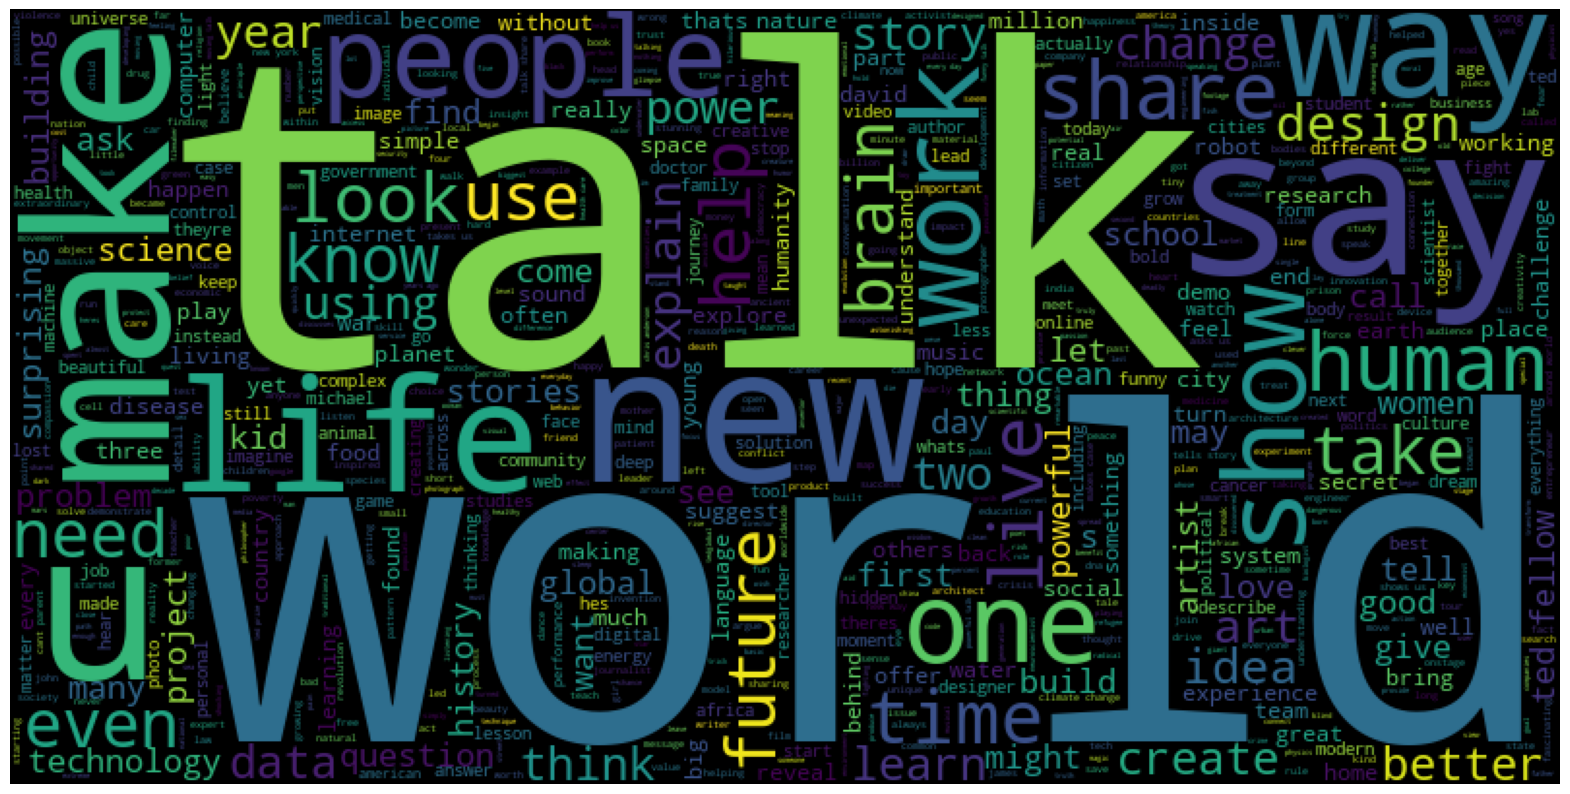

In [31]:
details_corpus = " ".join(df['description'])
 
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000,
               width=800,
               height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

In [32]:
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['description'])

TfidfVectorizer()

In [35]:
def get_similarities(talk_content, data=df):
 
    # Getting vector for the input talk_content.
    talk_array1 = vectorizer.transform(talk_content).toarray()
 
    # We will store similarity for each row of the dataset.
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['description']
 
        # Getting vector for current talk.
        talk_array2 = vectorizer.transform(
            data[data['description'] == details]['description']).toarray()
 
        # Calculating cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
 
        # Calculating pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]
 
        sim.append(cos_sim)
        pea.append(pea_sim)
 
    return sim, pea

In [36]:
def recommend_talks(talk_content, data=data):
 
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
 
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
                     False, False], inplace=True)
 
    display(data[['main_speaker', 'description']].head())

In [37]:
talk_content = ['Time Management and working\
hard to become successful in life']
recommend_talks(talk_content)

,main_speaker,description
2347,Laura Vanderkam,Laura Vanderkam: How to gain control of your f...
2430,Chimamanda Ngozi Adichie,Chimamanda Ngozi Adichie: We should all be fem...
2406,Karina Galperin,Karina Galperin: Should we simplify spelling? ...
1270,Nirmalya Kumar,Nirmalya Kumar: India's invisible innovation C...
67,Seth Godin,Seth Godin: How to get your ideas to spread In...


In [38]:
talk_content = ['Climate change and impact on the health\
. How can we change this world by reducing carbon footprints?']
recommend_talks(talk_content)

,main_speaker,description
1203,Tal Golesworthy,Tal Golesworthy: How I repaired my own heart T...
1957,Takaharu Tezuka,Takaharu Tezuka: The best kindergarten you’ve ...
2314,Kelli Jean Drinkwater,Kelli Jean Drinkwater: Enough with the fear of...
2348,David Autor,David Autor: Will automation take away all our...
2399,Caroline Paul,"Caroline Paul: To raise brave girls, encourage..."
